In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest



sns.set_style('whitegrid')

import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(10,5)})

if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()
os.chdir(root)

from tools.add_AR_cols import add_AR_cols
from data_treatment.box_creator import create_binary_box
PATH = "../"

In [482]:
df = pd.read_csv('database.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = create_binary_box(df, relative_threshold = 0.05, box_length=5).set_index(['Date']).dropna(axis = 0)
df[['PX_OPEN_VIX_volatility','Box']]
df = add_AR_cols(df,7)

In [496]:
y = df['Box']
X = df.drop(['Box', 'Neutral_SENTIMENT', 'Bull-Bear Spread_SENTIMENT'], axis=1)

In [497]:
selec_model = SelectKBest(k=40)
selec_model.fit(X, y)
selected_cols = selec_model.get_feature_names_out()

X= X[selected_cols]

In [498]:
coeffs_list =[]
c_s = np.geomspace(1,1e8,100)

lasso = LogisticRegression(C=1/c_s[0], fit_intercept=True, penalty='l1', solver='saga')
lasso.fit(X,y)
coeffs_list.append(lasso.coef_[0])

X =X [np.array(X.columns)[coeffs_list[0]!=0]]

tab_coeff = np.empty([len(c_s)-1,len(X.columns)])

c_s = c_s[1:]

for i in range(len(c_s)):
    lasso = LogisticRegression(C=1/c_s[i], fit_intercept=True, penalty='l1', solver='saga')
    lasso.fit(X,y)
    tab_coeff[i,:]= lasso.coef_[0]

In [499]:
coeff_df = pd.DataFrame(data=tab_coeff[::-1], index=c_s[::-1], columns=X.columns)
coeff_df["Valid cols"] = coeff_df[coeff_df!=0].count(axis=1)

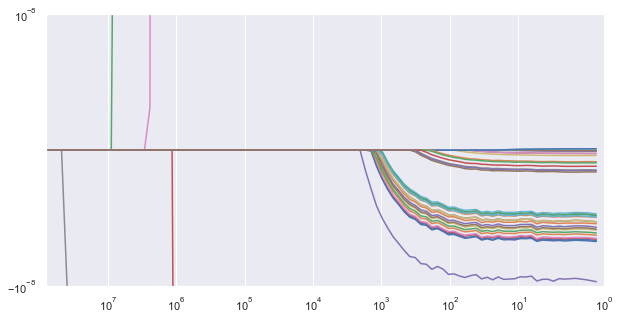

In [500]:
plot = coeff_df.drop("Valid cols", axis=1).plot(legend= False, logx='sym', logy='sym',xlim = [8e7, 1], ylim=[-1e-8, 1e-8])
plt.show()

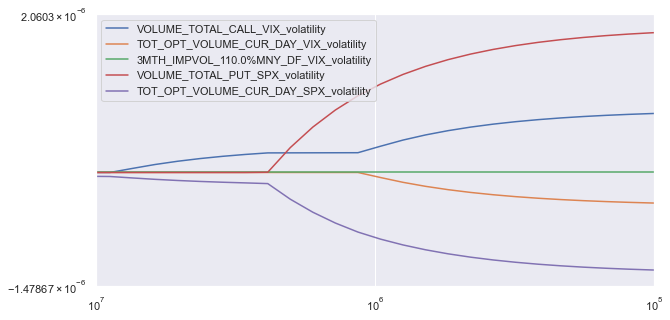

In [501]:
first_cols = coeff_df[coeff_df['Valid cols']==5][coeff_df!=0].dropna(axis=1).columns

plot = coeff_df[first_cols].drop("Valid cols", axis=1).plot( logx='sym', logy='sym',xlim = [1e7, 1e5])
plt.show()